✅ Environnement Random Forest prêt (Python 3.14 compatible)
✅ Features créées : 12 variables
✅ Jeu de données prêt : (100, 12) features : 12
⏳ Entraînement du modèle Random Forest baseline...
✅ MAE moyenne (baseline RF) : 170.80
🔍 Lancement de la recherche d'hyperparamètres...
✅ Meilleurs paramètres trouvés : {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 15, 'bootstrap': True}
⚙️ Évaluation du modèle optimisé...
📉 MAE moyenne (RF optimisé) : 169.25


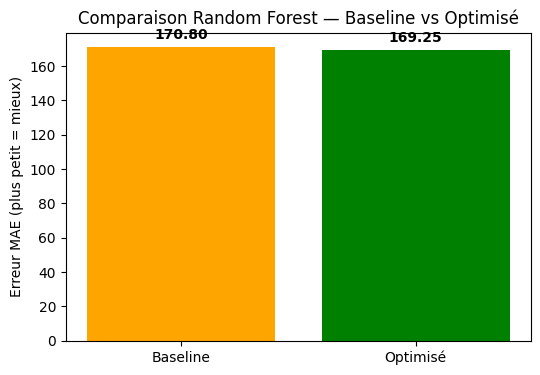

💾 Modèle Random Forest optimisé sauvegardé dans models/rf_best_model.pkl


/Users/tonytillet/Documents/epitech/T-HAK-700/t-hack-700/venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


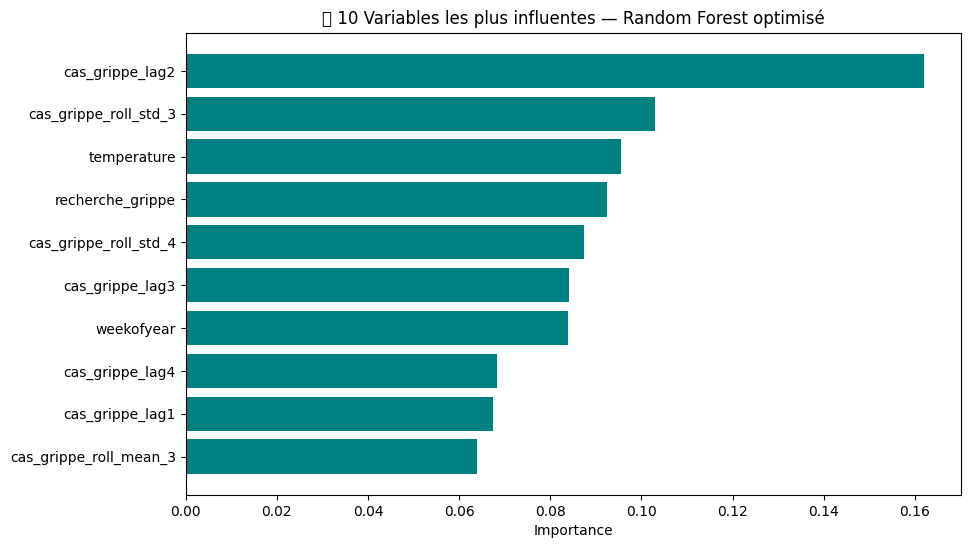

In [14]:
# ================================================================
# 🔹 1. Import des librairies
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import joblib

print("✅ Environnement Random Forest prêt (Python 3.14 compatible)")

# ================================================================
# 🔹 2. Génération / Chargement des données
# ================================================================
# (ici on simule des données ; tu pourras remplacer par un CSV réel plus tard)
dates = pd.date_range(start="2022-01-01", periods=104, freq="W")
cas_grippe = np.random.randint(200, 1000, size=len(dates))
temperature = np.random.normal(12, 6, size=len(dates))
recherche_grippe = np.random.randint(50, 200, size=len(dates))

df = pd.DataFrame({
    "date": dates,
    "cas_grippe": cas_grippe,
    "temperature": temperature,
    "recherche_grippe": recherche_grippe
})

# ================================================================
# 🔹 3. Feature Engineering (lags, rolling means, temporal features)
# ================================================================
def add_lags(df, col, lags):
    for lag in lags:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df

def add_rollings(df, col, windows):
    for w in windows:
        df[f"{col}_roll_mean_{w}"] = df[col].shift(1).rolling(w).mean()
        df[f"{col}_roll_std_{w}"] = df[col].shift(1).rolling(w).std()
    return df

df = df.sort_values("date")
df = add_lags(df, "cas_grippe", [1, 2, 3, 4])
df = add_rollings(df, "cas_grippe", [3, 4])
df["month"] = df["date"].dt.month
df["weekofyear"] = df["date"].dt.isocalendar().week
df = df.dropna().reset_index(drop=True)

print("✅ Features créées :", len(df.columns) - 2, "variables")

# ================================================================
# 🔹 4. Préparation des données
# ================================================================
features = [col for col in df.columns if col not in ["date", "cas_grippe"]]
X = df[features]
y = df["cas_grippe"]

print("✅ Jeu de données prêt :", X.shape, "features :", len(features))

# ================================================================
# 🔹 5. Validation temporelle (TimeSeriesSplit) — Baseline RF
# ================================================================
tscv = TimeSeriesSplit(n_splits=5)
baseline_mae = []

print("⏳ Entraînement du modèle Random Forest baseline...")
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf_baseline = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=1
    )
    rf_baseline.fit(X_train, y_train)
    y_pred = rf_baseline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    baseline_mae.append(mae)

print(f"✅ MAE moyenne (baseline RF) : {np.mean(baseline_mae):.2f}")

# ================================================================
# 🔹 6. Optimisation automatique (RandomizedSearchCV)
# ================================================================
rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

print("🔍 Lancement de la recherche d'hyperparamètres...")
search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=15,
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(n_splits=5),
    random_state=42,
    n_jobs=1
)

search.fit(X, y)
best_rf = search.best_estimator_
print("✅ Meilleurs paramètres trouvés :", search.best_params_)

# ================================================================
# 🔹 7. Évaluation du modèle optimisé
# ================================================================
tscv = TimeSeriesSplit(n_splits=5)
optimized_mae = []

print("⚙️ Évaluation du modèle optimisé...")
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_rf.fit(X_train, y_train)
    y_pred = best_rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    optimized_mae.append(mae)

print(f"📉 MAE moyenne (RF optimisé) : {np.mean(optimized_mae):.2f}")

# ================================================================
# 🔹 8. Visualisation comparative
# ================================================================
labels = ["Baseline", "Optimisé"]
mae_values = [np.mean(baseline_mae), np.mean(optimized_mae)]

plt.figure(figsize=(6,4))
plt.bar(labels, mae_values, color=['orange', 'green'])
plt.ylabel("Erreur MAE (plus petit = mieux)")
plt.title("Comparaison Random Forest — Baseline vs Optimisé")
for i, v in enumerate(mae_values):
    plt.text(i, v + 5, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

# ================================================================
# 🔹 9. Sauvegarde du meilleur modèle
# ================================================================
joblib.dump(best_rf, "../models/rf_best_model.pkl")
print("💾 Modèle Random Forest optimisé sauvegardé dans models/rf_best_model.pkl")

# ================================================================
# 🔹 10. Interprétation des features les plus importantes
# ================================================================
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importances["Feature"].head(10), importances["Importance"].head(10), color="teal")
plt.gca().invert_yaxis()
plt.title("🔍 10 Variables les plus influentes — Random Forest optimisé")
plt.xlabel("Importance")
plt.show()
